[ AiDALab 양석환 | NLP - 08 ]

---

- 참고도서
  - 김기현의 자연어 처리 딥러닝 캠프-파이토치 편(김기현 : 한빛미디어)
  - 처음 배우는 딥러닝 챗봇 (조경래, 한빛미디어)
  - 밑바닥부터 시작하는 딥러닝 2 (사이토 고키 / 개앞맵시 : 한빛미디어)
<br><br>
- 참고사이트
  - https://medium.com/district-data-labs/forward-propagation-building-a-skip-gram-net-from-the-ground-up-9578814b221
---

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)
DATA_PATH = "/gdrive/My Drive/Lectures/NLP/data/"

Mounted at /gdrive


# **임베딩**

## Ⅰ. 단어의 벡터 표현

### 1.1 원핫 인코딩

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.datasets import load_iris

import pandas as pd
import numpy as np

In [4]:
items = ['TV', '냉장고', '전자렌지', '컴퓨터', '선풍기', '선풍기', '믹서', '믹서']

encoder = LabelEncoder()
encoder.fit(items)
labels = encoder.transform(items)
labels

array([0, 1, 4, 5, 3, 3, 2, 2])

In [5]:
labels = labels.reshape(-1, 1)
labels

array([[0],
       [1],
       [4],
       [5],
       [3],
       [3],
       [2],
       [2]])

In [6]:
oh_encoder = OneHotEncoder()
oh_encoder.fit(labels)
oh_labels = oh_encoder.transform(labels)

oh_array = oh_labels.toarray()
print(oh_array)
print(oh_array.shape)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
(8, 6)


In [7]:
df = pd.DataFrame({'items': items})
df

,items
0,TV
1,냉장고
2,전자렌지
3,컴퓨터
4,선풍기
5,선풍기
6,믹서
7,믹서


In [8]:
pd.get_dummies(df)

,items_TV,items_냉장고,items_믹서,items_선풍기,items_전자렌지,items_컴퓨터
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,1,0
3,0,0,0,0,0,1
4,0,0,0,1,0,0
5,0,0,0,1,0,0
6,0,0,1,0,0,0
7,0,0,1,0,0,0


## Ⅱ. 단어의 이용

### 2.1 시소러스 기법

#### 2.1.1 WordNet
- WordNet을 사용하기 위한 준비

In [9]:
import nltk
nltk.download('wordnet')      # 이 코드를 실행하지 않으면 동작하지 않음

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [10]:
from nltk.corpus import wordnet

- "car"라는 단어가 가지고 있는 그룹 확인하기
  - "car"라는 단어에는 다섯 가지 의미(정확하게는 5개의 서로 다른 동의어 그룹)가 정의되어 있다는 뜻임


In [11]:
wordnet.synsets('car')

[Synset('car.n.01'),
 Synset('car.n.02'),
 Synset('car.n.03'),
 Synset('car.n.04'),
 Synset('cable_car.n.01')]

- 동의어 그룹을 지정하여 그 정의를 확인하기
  - "car.n.01" 의 의미는 "네개의 바퀴를 가진 차량. 일반적으로 내연기관에 의해 움직인다"임
  - "car.n.02"의 의미는 "철도 레일에 적합한 바퀴 달린 차량"을 의미함

In [17]:
car = wordnet.synset('car.n.01')    # 동의어 그룹 지정
car.definition()

'a motor vehicle with four wheels; usually propelled by an internal combustion engine'

In [20]:
car2 = wordnet.synset('car.n.02')    # 동의어 그룹 지정
car2.definition()

'a wheeled vehicle adapted to the rails of railroad'

- 동의어 그룹에 속한 단어들의 이름 가져오기

In [18]:
car.lemma_names()

['car', 'auto', 'automobile', 'machine', 'motorcar']

In [21]:
car2.lemma_names()

['car', 'railcar', 'railway_car', 'railroad_car']

- WordNet과 단어 네트워크 확인
  - "car"의 단어 네트워크를 사용하여 다른 단어와의 의미적인 상하관계 살펴보기
  - "entity > physical_entity > object > ... > motor_vehicle > car"의 경로를 따라감을 알 수 있음
  - WordNet을 구성하는 단어 네트워크는 위로 갈수록 추상적이고, 아래로 갈수록 구체적인 단어로 배치됨

In [22]:
car.hypernym_paths()[0]

[Synset('entity.n.01'),
 Synset('physical_entity.n.01'),
 Synset('object.n.01'),
 Synset('whole.n.02'),
 Synset('artifact.n.01'),
 Synset('instrumentality.n.03'),
 Synset('container.n.01'),
 Synset('wheeled_vehicle.n.01'),
 Synset('self-propelled_vehicle.n.01'),
 Synset('motor_vehicle.n.01'),
 Synset('car.n.01')]

- WordNet을 사용한 의미 유사도 계산
  - car(자동차) 단어와 novel(소설), dog(개), motorcycle(오토바이) 단어를 비교하기
  - "motorcycle"이 다른 단어보다 몇 배나 높은 유사도를 가지는 것을 확인할 수 있음

In [23]:
car = wordnet.synset('car.n.01')
novel = wordnet.synset('novel.n.01')
dog = wordnet.synset('dog.n.01')
motorcycle = wordnet.synset('motorcycle.n.01')

In [24]:
car.path_similarity(novel)

0.05555555555555555

In [25]:
car.path_similarity(dog)

0.07692307692307693

In [26]:
car.path_similarity(motorcycle)

0.3333333333333333

#### 2.1.2 특징 추출
- TF-IDF 예제

In [27]:
import pandas as pd

In [28]:
# 세 강읜의 스크립트가 담긴 문서(doc1, doc2, doc3)
doc1 = '''
지능 지수 라는 말 들 어 보 셨 을 겁니다 . 여러분 의 지성 을 일컫 는 말 이 죠 . 그런데 심리 지수 란 건 뭘까요 ? 사람 들 이 특정 한 식 으로 행동 하 는 이유 에 대해 여러분 은 얼마나 알 고 계시 나요 ? 또 타인 이나 심지어 여러분 의 행동 을 예측 하 는 일 은 얼마나 잘 하 시 나요 ? 또 , 심리학 에 대해 갖춘 지식 중 에서 어느 정도 나 잘못 된 것 일까요 ? 심리학 에 관한 열 가지 신화 를 통해 잘못 된 것 들 을 알아보 도록 하 죠 . 여러분 은 한 번 쯤 들 어 보 셨 을 법 한 것 은 자신 들 의 심리학 에 대해 고려 할 때 , 거의 항상 남자 는 화성 에서 왔 고 , 여자 는 금성 에서 온 것 같 다고 합니다 . 하지만 실제로 남자 와 여자 는 얼마나 다른 걸까요 ? 이 를 알아보 기 위해 , 일단 남녀 사이 에 확실 하 게 차이 나 는 것 을 살펴보 고 심리학 적 인 성별 간 의 차이점 을 동일 한 척도 상 에서 대비 해 보 도록 하 겠 습니다 . 남자 와 여자 간 에 실제로 차이 나 는 능력 중 하나 는 그 들 이 공 을 얼마나 멀리 던질 수 있 느냐 하 는 것 입니다 . 여기 남자 들 의 데 이타 를 보 시 면 , 정상 분포 곡선 이 라는 걸 볼 수 있 습니다 . 남자 들 소수 는 정말 멀리 던지 고 , 남자 들 소수 는 멀리 던지 지 못하 지만 , 남자 들 대부분 은 평균 적 인 거리 를 던졌 습니다 . 여자 들 도 역시 비슷 한 분포 상태 를 보입니다 만 사실 남녀 사이 엔 커다란 차이 가 있 습니다 . 사실 , 평균 수준 의 남자 라면 모든 여성 중 대략 98 % 보다 더 멀리 던질 수 있 거든요 . 이 와 동일 하 게 표준 화 된 척도 상 에서 심리학 에서 말 하 는 성별 간 의 차이 를 살펴 봅시다 . 심리학자 라는 여러분 에게 말 하 길 남자 들 의 공간 지각 능력 이 여자 들 보다 뛰어나 다고 할 겁니다 . 예 를 들 어 , 지도 읽 는 능력 같 은 건데 , 맞 는 말 입니다 . 하지만 그 차이 의 정도 를 살펴봅시다 . 아주 작 죠 . 두 선 이 너무 근접 해서 거의 겹칠 정도 입니다 .
'''

doc2 = '''
최상 의 제시 유형 은 학습 자 에 좌우 되 는 것 이 아니 라 학습 해야 할 내용 에 따라 좌우 됩니다 . 예 를 들 어 여러분 이 운전 하 기 를 배울 때 실제로 몸 으로 체감 하 는 경험 없이 누군가 가 어떻게 할 지 이야기 하 는 것 을 듣 는 것 만 으로 배울 수 있 습니까 ? 연립 방정식 을 풀 어야 하 는데 종이 에 쓰 지 않 고 머리 속 에서 말 하 는 것 으로 풀 수 가 있 을까요 ? 또는 만일 여러분 이 체감 형식 의 학습 자 유형 이 라면 , 건축학 시험 을 해석 적 춤 을 이용 하 여 수정 할 수 있 을까요 ? 아니 죠 ! 배워야 할 내용 을 제시 된 유형 에 맞추 어야 합니다 , 당신 에게 맞추 는 게 아니 라요 . 여러분 들 상당수 가 " A " 급 의 우등 생 이 라는 걸 아 는데 , 조만간 중등 학력 인증 시험 ( GCSE ) 결과 를 받 게 되 시 겠 네요 . 그런데 , 만일 , 여러분 들 이 희망 했 던 성적 을 받 지 못하 게 된다 해도 여러분 들 의 학습 방식 을 탓 해서 는 안 되 는 겁니다 . 여러분 이 비난 할 수 있 는 한 가지 는 바로 유전자 입니다 . 이건 최근 에 런던 대학교 ( UCL ) 에서 수행 했 던 연구 결과 는 여러 학생 들 과 그 들 의 중등 학력 인증 시험 결과 사이 의 차이 중 58 % 는 유전 적 인 요인 으로 좁혀졌 습니다 . 매우 정밀 한 수치 처럼 들립니다 . 그러면 어떻게 알 수 있 을까요 ? 유전 적 요인 과 환경 적 요인 의 상대 적 기여 도 를 알 고 싶 을 때 우리 가 사용 할 수 있 는 방식 은 바로 쌍둥이 연구 입니다 . 일 란 성 쌍생아 의 경우 환경 적 요인 과 유전 적 요인 모두 를 100 % 똑같이 공유 하 게 되 지만 이란 성 쌍생아 의 경우 는 100 % 동일 한 환경 을 공유 하 지만 유전자 의 경우 여타 의 형제자매 들 처럼 50 % 만 공유 하 게 됩니다 . 따라서 일 란 성 쌍둥이 와 이란 성 쌍둥이 사이 의 인증 시험 결과 가 얼마나 비슷 한지 비교 해 보 고 여기 에 약간 의 수학 적 계산 을 더하 게 되 면 그 수행 능력 의 차이 중 어느 정도 가 환경 적 요인 의 탓 이 고 어느 정도 가 유전자 탓 인지 를 알 수 있 게 됩니다 .
'''

doc3 = '''
그러나 이 이야기 는 세 가지 이유 로 인해 신화 입니다 . 첫째 , 가장 중요 한 건 실험실 가운 은 흰색 이 아니 라 회색 이 었 다 라는 점 이 죠 . 둘째 , 참 여자 들 은 실험 하 기 전 에 와 참여 자 들 이 걱정 을 표현 할 때 마다 상기 시키 는 말 을 들 었 는데 , 전기 충격 이 고통 스럽 기 는 하 지만 , 치명 적 이 지 는 않 으며 실제로 영구 적 인 손상 을 남기 는 일 은 없 을 거 라는 것 이 었 습니다 . 셋째 , 참 여자 들 은 단지 가운 을 입 은 사람 이 시켜 전기 충격 을 주지 는 않 았 죠 . 실험 이 끝나 고 그 들 의 인터뷰 를 했 을 때 모든 참여 자 들 은 강한 신념 을 밝혔 는데 , ' 학습 과 처벌 ' 연구 가 과학 적 으로 가치 있 는 목적 을 수행 했 기 때문 에 비록 동료 참여 자 들 에게 가해진 순간 적 인 불편 함 에 반해서 과학 을 위해서 오래 남 을 성과 를 얻 을 것 이 라고 말 이 죠 . 그러 다 보 니 제 가 이야기 를 한 지 벌써 12 분 이 되 었 습니다 . 여러분 들 중 에 는 아마 거기 앉 아서 제 이야기 를 들으시는 동안 저 의 말투 와 몸짓 을 분석 하 면서 제 가 말 하 는 어떤 것 을 인지 해야 할까 해결 하 려고 하 셨 을 겁니다 , 제 가 진실 을 이야기 하 는 지 , 또는 거짓말 을 하 고 있 는 것 인지 말 이 죠 . 만일 그러 셨 다면 , 아마 지금 쯤 완전히 실패 하 셨 을 겁니다 . 왜냐하면 우리 모두 가 사람 이 말 하 는 패턴 과 몸짓 으로 도 거짓말 여부 를 알아내 는 것 이 가능 하 다고 생각 하 지만 , 오랜 세월 수백 회 에 걸쳐 행해진 실제 심리 검사 의 결과 를 보 면 우리 들 모두 는 , 심지어 경찰관 이나 탐정 들 을 포함 해서 도 기본 적 으로 몸짓 과 언어 적 패턴 으로 거짓말 을 탐지 하 는 것 은 운 에 맞 길 수 밖 에 는 없 는 것 입니다 . 흥미 롭 게 도 한 가지 예외 가 있 는데요 : 실종 된 친척 을 찾 아 달 라고 호소 하 는 TV 홍보 입니다 .
'''

In [29]:
# 특정 문서가 주어졌을 때, 문서 내의 단어들의 출현 빈도를 세는 함수
def get_term_frequency(document, word_dict=None):
    if word_dict is None:
        word_dict = {}
    words = document.split()

    for w in words:
        word_dict[w] = 1 + (0 if word_dict.get(w) is None else word_dict[w])

    return pd.Series(word_dict).sort_values(ascending=False)

In [30]:
get_term_frequency(doc1)

.     16
는     15
들     14
,     10
하     10
      ..
정상     1
면      1
이타     1
데      1
지능     1
Length: 186, dtype: int64

In [31]:
# 문서들이 주어졌을 때 각 단어가 몇 개의 문서에서 나타났는지 세는 함수
def get_document_frequency(documents):
    dicts = []
    vocab = set([])
    df = {}

    for d in documents:
        tf = get_term_frequency(d)
        dicts += [tf]
        vocab = vocab | set(tf.keys())
    
    for v in list(vocab):
        df[v] = 0
        for dict_d in dicts:
            if dict_d.get(v) is not None:
                df[v] += 1

    return pd.Series(df).sort_values(ascending=False)

In [32]:
get_document_frequency([doc1, doc2])

예      2
실제로    2
으로     2
수      2
일      2
      ..
우등     1
연구     1
환경     1
사실     1
맞      1
Length: 311, dtype: int64

In [33]:
def get_tfidf(docs):
    vocab = {}
    tfs = []
    for d in docs:
        vocab = get_term_frequency(d, vocab)
        tfs += [get_term_frequency(d)]
    df = get_document_frequency(docs)

    from operator import itemgetter
    import numpy as np

    stats = []
    for word, freq in vocab.items():
        tfidfs = []
        for idx in range(len(docs)):
            if tfs[idx].get(word) is not None:
                tfidfs += [tfs[idx][word] * np.log(len(docs) / df[word])]
            else:
                tfidfs += [0]

        stats.append((word, freq, *tfidfs, max(tfidfs)))

    return pd.DataFrame(stats, columns=('word',
                                        'frequency',
                                        'doc1',
                                        'doc2',
                                        'doc3',
                                        'max')).sort_values('max', ascending=False)

In [34]:
get_tfidf([doc1, doc2, doc3])

,word,frequency,doc1,doc2,doc3,max
23,남자,9,9.887511,0.000000,0.000000,9.887511
37,요인,6,0.000000,6.591674,0.000000,6.591674
51,심리학,5,5.493061,0.000000,0.000000,5.493061
57,었,4,0.000000,0.000000,4.394449,4.394449
63,제,4,0.000000,0.000000,4.394449,4.394449
...,...,...,...,...,...,...
36,라는,6,0.000000,0.000000,0.000000,0.000000
33,중,6,0.000000,0.000000,0.000000,0.000000
30,습니다,7,0.000000,0.000000,0.000000,0.000000
29,보,7,0.000000,0.000000,0.000000,0.000000


doc1에서 가장 중요한 단어는 "남자", doc2에서 가장 중요한 단어는 "요인"

#### 2.1.3 특징 벡터 만들기

In [35]:
# TF 행렬 만들기
def get_tf(docs):
    vocab = {}
    tfs = []
    for d in docs:
        vocab = get_term_frequency(d, vocab)
        tfs += [get_term_frequency(d)]

    from operator import itemgetter
    import numpy as np

    stats = []
    for word, freq in vocab.items():
        tf_v = []
        for idx in range(len(docs)):
            if tfs[idx].get(word) is not None:
                tf_v += [tfs[idx][word]]
            else:
                tf_v += [0]
        stats.append((word, freq, *tf_v))
    
    return pd.DataFrame(stats, columns=('word',
                                        'frequency',
                                        'doc1',
                                        'doc2',
                                        'doc3')).sort_values('frequency', ascending=False)

get_tf([doc1, doc2, doc3])

,word,frequency,doc1,doc2,doc3
0,는,47,15,14,18
1,을,39,8,10,21
2,.,36,16,10,10
3,하,33,10,9,14
4,이,32,8,8,16
...,...,...,...,...,...
273,스럽,1,0,0,1
274,치명,1,0,0,1
275,으며,1,0,0,1
276,영구,1,0,0,1


- get_tf의 결과
  - 각 단어들에 대한 TF에서 doc1, doc2, doc3의 단어별 출현횟수가 특징벡터로 사용됨
  - 예를 들어 "여러분"이라는 단어는 [5, 6, 1]이라는 특징벡터를 가짐
  - 단순히 문서에서의 출현 횟수만으로 특징 벡터를 구성하다보니 많은 정보가 유실됨

---

### 2.2 통계 기반 기법

#### 2.2.1 말뭉치 전처리하기

In [36]:
text = "You say goodbye and I say hello."
text = text.lower()                 # 대소문자 구분없이 모든 철자를 똑같은 조건으로 처리하기 위하여 모든 글자를 소문자로 변경함
text = text.replace('.', ' .')      # 간단하게 띄어쓰기만으로 단어를 분리하기 위하여 마침표(.) 앞에 공백을 추가함
print(text)

you say goodbye and i say hello .


In [37]:
words = text.split(' ')
print(words)

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [38]:
# 단어를 텍스트 그대로 조작하기 어려우므로 각 단어별로 ID를 부여하여 ID의 리스트로 이용할 수 있도록 처리
word_to_id = {}
id_to_word = {}

for word in words:
  if word not in word_to_id:
    new_id = len(word_to_id)
    word_to_id[word] = new_id
    id_to_word[new_id] = word

In [39]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [40]:
word_to_id

{'.': 6, 'and': 3, 'goodbye': 2, 'hello': 5, 'i': 4, 'say': 1, 'you': 0}

In [41]:
# 단어로 ID 검색, ID로 단어 검색이 가능해짐
print(id_to_word[1])
print(word_to_id['hello'])

say
5


In [42]:
# "단어 목록"을 "단어 ID 목록"으로 변경
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [43]:
import sys
import numpy as np

In [44]:
# 지금까지의 과정을 함수로 구현하여 호출하기 편하게 만들자
def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')

  word_to_id = {}
  id_to_word = {}

  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = np.array([word_to_id[w] for w in words])
  return corpus, word_to_id, id_to_word

In [45]:
text = "You say goodbye and hello."
corpus, word_to_id, id_to_word =preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 5]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'hello', 5: '.'}


#### 2.2.2 분포가설과 동시발생 행렬

In [46]:
C = np.array([
              [0, 1, 0, 0, 0, 0, 0],
              [1, 0, 1, 0, 1, 1, 0],
              [0, 1, 0, 1, 0, 0, 0],
              [0, 0, 1, 0, 1, 0, 0],
              [0, 1, 0, 1, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 1, 0],
], dtype=np.int32)

In [47]:
print(C[0])
print(C[4])
print(C[word_to_id['goodbye']])

[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]
[0 1 0 1 0 0 0]


In [48]:
# 동시발생 행렬을 만들어주는 함수
def create_co_matrix(corpus, vocab_size, window_size=1):
  corpus_size = len(corpus)
  co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

  for idx, word_id in enumerate(corpus):
    for i in range(1, window_size + 1):
      left_idx = idx - i
      right_idx = idx + i

      if left_idx >= 0:
        left_word_id = corpus[left_idx]
        co_matrix[word_id, left_word_id] += 1

      if right_idx < corpus_size:
        right_word_id = corpus[right_idx]
        co_matrix[word_id, right_word_id] += 1

  return co_matrix

text = "You say goodbye and hello."
corpus, word_to_id, id_to_word =preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)
print(C)

[[0 1 0 0 0 0]
 [1 0 1 0 0 0]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 0 0 1 0 1]
 [0 0 0 0 1 0]]


#### 2.2.3 벡터간 유사도
- 분모에 eps를 더하는 이유: 인수로 제로벡터가 들어오면 0으로 나누기 오류 발생 --> eps를 더해줌으로써 오류 회피 가능

In [49]:
def cos_similarity(x, y, eps=1e-8):
  nx = x / (np.sqrt(np.sum(x**2)) + eps)    # x의 정규화
  ny = y / (np.sqrt(np.sum(y**2)) + eps)    # y의 정규화
  return np.dot(nx, ny)

In [50]:
import sys

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word =preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067691154799


- 유사도가 0.70... 으로 나옴 → 코사인 유사도의 값은 -1에서 1사이. 따라서 0.7은 유사성이 크다. 라고 할 수 있다.

#### 2.2.4 유사 단어의 랭킹 표시
- 어떤 단어가 주어지면 그 검색어와 비슷한 단어를 유사도 순으로 출력해보기
- most_similar(query, word_to_id, id_to_word, word_matrix, top=5)
  - query: 검색어(단어)
  - word_to_id: 단어에서 단어 ID로의 딕셔너리
  - id_to_word: 단어 ID에서 단어로의 딕셔너리
  - word_matrix: 단어 벡터들을 한데 모은 행렬. 각 행에는 대응하는 단어의 벡터가 저장되어 있다고 가정함
  - top: 상위 몇 개까지 출력할지 설정

In [51]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
  # 검색어의 단어벡터 꺼내기
  if query not in word_to_id:
    print('%s(을)을 찾을 수 없습니다.' % query)
    return
  
  print('\n[query] ' + query)
  query_id = word_to_id[query]
  query_vec = word_matrix[query_id]

  # 검색어의 단어벡터와 다른 모든 단어벡터와의 코사인 유사도를 각각 계산한다
  vocab_size = len(id_to_word)
  similarity = np.zeros(vocab_size)

  for i in range(vocab_size):
    similarity[i] = cos_similarity(word_matrix[i], query_vec)

  # 코사인 유사도를 기준으로 내림차순으로 출력
  count = 0
  for i in (-1 * similarity).argsort():     # argsort(): 넘파이 배열의 원소를 오름차순으로 정렬. 반환값은 배열의 인덱스
    if id_to_word[i] == query:
      continue
    print(' %s: %s' % (id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
      return

In [52]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word =preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


- you가 i와 유사성이 있다는 것은 이해가 가지만 goodbye, hello와 유사성이 있다는 것은 이해가 가지 않음
- 말뭉치의 크기가 너무 작아서 그럼

#### 2.2.5 통계 기반 기법의 개선
- 점별 상호정보량 (Pointwise Mutual Information, PMI)
  - ppmi 함수: 동시발생 행렬을 PPMI 햏렬로 변환하는 함수
    - C: 동시발생 행렬
    - verbose: 진행상황 출력 여부를 결정하는 플래그
    - eps: np.log2(0)가 음의 무한대가 되는 경우를 피하기 위한 값

In [53]:
def ppmi(C, verbose=False, eps=1e-8):
  M = np.zeros_like(C, dtype=np.float32)
  N = np.sum(C)
  S = np.sum(C, axis=0)
  total = C.shape[0] * C.shape[1]
  cnt = 0

  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
      M[i, j] = max(0, pmi)

      if verbose:
        cnt += 1
        if cnt % (total //100) == 0:
          print('%.1f%% 완료' % (100 * cnt / total))
      
  return M

In [54]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word =preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)

W = ppmi(C)

np.set_printoptions(precision=3)    # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0 0]
 [1 0 1 0 1 1 0 0]
 [0 1 0 1 0 0 0 0]
 [0 0 1 0 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807 0.   ]
 [0.    0.    0.    0.    0.    2.807 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


- SVD에 의한 차원감소
  - SVD에 의해 변환된 밀집벡터는 U에 저장됨
  - 밀집벡터의 차원을 감소시키려면 원하는 차원만큼 순서대로 읽어오면 됨
    - 예: 2차원 벡터로 줄이려면 U[0, :2]

In [55]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word =preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)

W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)      # 넘파이에서 기본적으로 SVD 함수를 제공함

print(C[0])   # 동시발생 행렬
print('-'*50)
print(W[0])   # PPMI 행렬
print('-'*50)
print(U[0])   # SVD
print('-'*50)
print(U[0, :2])

[0 1 0 0 0 0 0 0]
--------------------------------------------------
[0.    1.807 0.    0.    0.    0.    0.    0.   ]
--------------------------------------------------
[-1.110e-16  3.409e-01 -4.163e-16 -1.205e-01 -1.110e-16 -9.323e-01
 -1.086e-16  0.000e+00]
--------------------------------------------------
[-1.110e-16  3.409e-01]


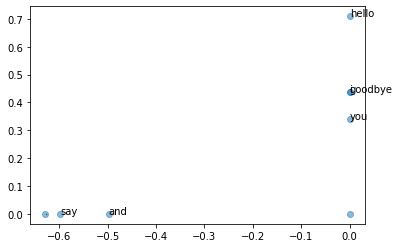

In [56]:
# 그래프 그려보기
for word, word_id in word_to_id.items():
  plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

goodbye와 hello, you와 i가 say, and에 비해 비교적 근처에 위치하고 있음을 확인할 수 있음.

- PTB 데이터 셋 사용

In [58]:
import sys
sys.path.append(DATA_PATH)
import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기: ', len(corpus))
print('corpus[:30]: ', corpus[:30])
print()
print('id_to_word[0]: ', id_to_word[0])
print('id_to_word[1]: ', id_to_word[1])
print('id_to_word[2]: ', id_to_word[2])
print()
print("word_to_id['car']: ", word_to_id['car'])
print("word_to_id['happy']: ", word_to_id['happy'])
print("word_to_id['lexus']: ", word_to_id['lexus'])

말뭉치 크기:  929589
corpus[:30]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]:  aer
id_to_word[1]:  banknote
id_to_word[2]:  berlitz

word_to_id['car']:  3856
word_to_id['happy']:  4428
word_to_id['lexus']:  7426


- PTB 데이터 셋 평가
  - PTB 데이터 셋에 통계 기반 기법을 적용해보기

In [59]:
import sys
sys.path.append(DATA_PATH)
import numpy as np
import ptb

import warnings
warnings.filterwarnings("ignore")

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)

print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('SVD 계산 ...')
try:
  # truncated SVD 사용(빠름)
  from sklearn.utils.extmath import randomized_svd
  U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
  # SVD (느림)
  U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

동시발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료
SVD 계산 ...


In [ ]:
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 i: 0.6790993213653564
 we: 0.6304163336753845
 'll: 0.5690501928329468
 do: 0.5326828956604004
 someone: 0.5177212357521057

[query] year
 month: 0.6843863725662231
 quarter: 0.6699827909469604
 last: 0.6038983464241028
 earlier: 0.603476881980896
 fiscal: 0.5989716649055481

[query] car
 auto: 0.6557837724685669
 luxury: 0.6109820008277893
 cars: 0.5265412926673889
 truck: 0.5113945007324219
 domestic: 0.48704907298088074

[query] toyota
 motor: 0.7058576941490173
 motors: 0.6929025650024414
 lexus: 0.6255307793617249
 nissan: 0.5963180661201477
 mazda: 0.5795055627822876


#### 2.2.6 텍스트의 탐색 실습

In [61]:
# NLTK가 제공하고 있는 책 데이터 다운로드
nltk.download('book')

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Package chat80 is already up-to-date!
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Package conll2000 is already up-to-date!
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Package conll2002 is already up-to-date!
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package dependency_treebank is already up-to-date!
[nltk_data]    | Downloadi

True

In [62]:
# NLTK가 내장하고 있는 책을 불러옴
from nltk.book import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [63]:
text1

<Text: Moby Dick by Herman Melville 1851>

In [64]:
# 이 소설의 전체 단어 수를 적으시오
print(str(len(text1)) + "개 입니다")

260819개 입니다


In [65]:
# 이 소설에 나오는 단어 중 중복을 제외한 고유한 단어의 수를 적으시오
print(str(len(set(text1))) + "개 입니다")

19317개 입니다


In [66]:
# 이 소설에 나오는 단어 중 중복을 제외한 고유한 단어를 적으시오
print(str(set(text1)))

{'frigate', 'wilderness', 'incidents', 'chambers', 'opulence', 'fares', 'Pass', 'IVORY', 'veal', 'pagan', 'extract', 'tinkling', 'initiated', 'insertion', 'stagnant', 'whittled', 'determinate', 'Fin', 'gigantic', 'cup', 'mace', 'interrogatively', 'martyr', 'cartload', 'fallen', 'Tash', 'things', 'vibration', 'Hearing', 'abundant', 'hourly', 'policemen', 'SCREWS', 'musket', 'Welding', 'marking', 'withhold', 'Algerine', 'conceivable', 'BOARD', 'joosy', 'dry', 'chancery', 'Cods', 'Arm', 'Sagittarius', 'fight', 'dictionaries', 'weepons', 'Therein', 'Flounders', 'Grampus', 'unseen', 'shakes', 'ay', 'occupation', 'Drink', 'tacit', 'morn', 'fac', 'paid', 'harmless', 'champions', 'excepting', 'thickens', 'pretending', 'Bellies', 'rotund', 'TWO', 'kitten', 'indisputable', 'embayed', 'killers', 'Pillar', 'ITS', 'inferior', 'questionings', 'TOOKE', 'Point', 'overawed', 'individualities', 'decorated', 'Wish', 'noses', 'footstep', 'maine', 'gliding', 'shadowy', 'glared', 'clan', 'hunks', 'melanchol

In [67]:
# 이 소설에서 고유한 단어는 보통 몇 번 정도 반복하여 등장하는지 확인하시오
len(text1) / len(set(text1))

13.502044830977896

- 모비딕 소설에서 각 단어는 평균 13.5회 사용되었음을 확인할 수 있음

In [68]:
# 이 소설의 단어의 출현 빈도를 확인하시오
text1.vocab()

FreqDist({'[': 3,
          'Moby': 84,
          'Dick': 84,
          'by': 1137,
          'Herman': 1,
          'Melville': 1,
          '1851': 3,
          ']': 1,
          'ETYMOLOGY': 1,
          '.': 6862,
          '(': 210,
          'Supplied': 2,
          'a': 4569,
          'Late': 1,
          'Consumptive': 1,
          'Usher': 2,
          'to': 4542,
          'Grammar': 2,
          'School': 1,
          ')': 78,
          'The': 612,
          'pale': 18,
          '--': 1070,
          'threadbare': 1,
          'in': 3916,
          'coat': 28,
          ',': 18713,
          'heart': 90,
          'body': 110,
          'and': 6024,
          'brain': 37,
          ';': 4072,
          'I': 2124,
          'see': 253,
          'him': 1058,
          'now': 646,
          'He': 230,
          'was': 1632,
          'ever': 203,
          'dusting': 2,
          'his': 2459,
          'old': 436,
          'lexicons': 1,
          'grammars': 2,
          '

- 각 토큰의 출현회수를 담은 FreqDist(Frequency Distribution) 객체를 반환함

In [ ]:
print(text1.vocab())

<FreqDist with 19317 samples and 260819 outcomes>


In [69]:
# 가장 많이 출현한 단어를 10개를 출력하시오
fd = text1.vocab()
fd.most_common(10)

[(',', 18713),
 ('the', 13721),
 ('.', 6862),
 ('of', 6536),
 ('and', 6024),
 ('a', 4569),
 ('to', 4542),
 (';', 4072),
 ('in', 3916),
 ('that', 2982)]

In [70]:
# "barbed"라는 단어가 몇 번 나오는지 확인하시오
print(fd.get('barbed'))

6


In [71]:
# 주어진 단어("school")가 포함된 문장, 문맥을 출력하시오
text1.concordance('school')

Displaying 10 of 10 matches:
Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in c
ality . " While you take in hand to school others , and to teach them by what 
 Pequod . She was a ship of the old school , rather small if anything ; with a
ee - beam , about two miles off ! a school of them !" Instantly all was commot
d . In cavalier attendance upon the school of females , you invariably see a m
whales is called by the fishermen a school , so is the lord and master of that
, so is the lord and master of that school technically known as the schoolmast
bly satirical , that after going to school himself , he should then go abroad 
 . But strike a member of the harem school , and her companions swim around he
he Pharaoh ' s . Methuselah seems a school - boy . I look round to shake hands


In [72]:
# 주어진 단어("school")와 비슷한 환경에서 쓰인 단어를 확인하시오.
# 같은 문맥에서 주어진 단어("school") 대신 사용된 횟수가 높은 단어를 찾습니다.
text1.similar('school')

man matter point cry sound whale roll day sea thing land king vessel
way ship head voyage weight sort fire


In [73]:
# 두 단어가 사용된 공통 문맥을 확인하시오
text1.common_contexts(['school', 'man'])

a_of the_of a_so


### 2.3 추론 기반 기법 

#### 2.3.1 신경망에 의한 변환
- 단어 ID가 0인 단어를 원핫 인코딩으로 표현한 다음 완전연결계층을 통과시켜 변환하는 작업
- 편향을 이용하지 않는 완전연결계층은 "행렬곱" 계산과 동일함

In [74]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])   # 입력
W = np.random.randn(7, 3)               # 가중치
h = np.matmul(c, W)                     # 중간 노드
print(h)

[[-0.202 -1.811 -1.991]]


#### 2.3.2 CBOW
- CBOW 모델의 추론 과정
  - CBOW 모델은 활성화 함수를 사용하지 않는 간단한 구성의 신경망 모델

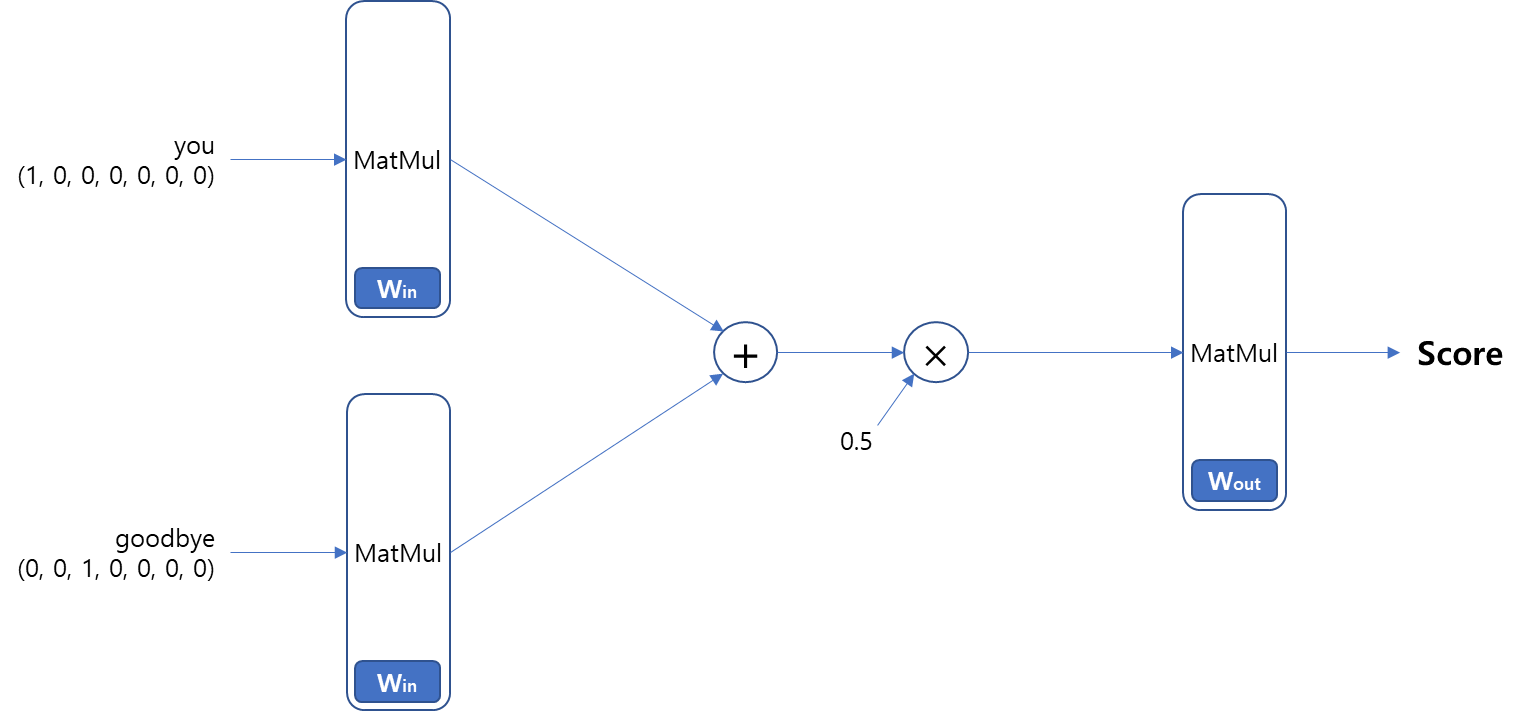

In [75]:
import numpy as np

In [76]:
class MatMul:                   # 행렬곱을 위한 클래스
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW

In [77]:
# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

# 결과는 각 단어의 점수
print(s)

[[ 0.307  0.598  0.194 -0.347 -0.428 -0.194  0.515]]


- CBOW 모델의 학습
  - 앞에서 계산한 각 단어의 점수에 Softmax 함수를 적용하여 확률 계산
  - 계산된 확률은 맥락(전후 단어)이 주어졌을때 그 중앙에 어떤 단어가 출현할 것인지에 대한 확률값
  - 신경망 모델의 다중 클래스 분류 신경망을 생각하면 쉽게 이해가 될 것임
  - CBOW 모델에 Softmax 계층과 Cross Entropy Error 계층을 추가함으로써 CBOW 모델의 손실을 계산할 수 있음

In [ ]:
# 전처리 함수
def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')

  word_to_id = {}
  id_to_word = {}

  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = np.array([word_to_id[w] for w in words])
  return corpus, word_to_id, id_to_word

In [83]:
# 맥락과 대상을 생성하는 함수
# [parameter] corpus: 말뭉치(단어 ID 목록)
#             window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [78]:
# 원핫 인코딩 변환 함수
# [parameter] corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
#             vocab_size: 어휘 수
# [return] 원핫 표현(2차원 또는 3차원 넘파이 배열)]
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

- 학습 데이터 준비

In [81]:
# 전처리
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print('-'*50)
print(id_to_word)

[0 1 2 3 4 1 5 6]
--------------------------------------------------
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [84]:
# 맥락과 타겟 만들기
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print('-'*50)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
--------------------------------------------------
[1 2 3 4 1 5]


In [85]:
# 원핫 인코딩 표현
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [86]:
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]], dtype=int32)

- CBOW 모델 구현

In [87]:
import numpy
import time
import matplotlib.pyplot as plt

In [88]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [89]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [ ]:
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx

In [90]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [ ]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [ ]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [ ]:
def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [ ]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

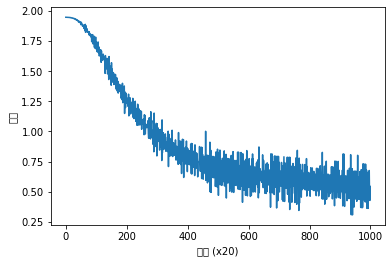

you [ 1.0404423 -1.2176622 -1.16512   -1.3006804  1.094287 ]
say [-1.3790065   0.20020254  0.37197188  0.2990422  -1.3533162 ]
goodbye [ 1.0526109 -0.6176288 -0.7009481 -0.4491432  1.0124508]
and [-1.1118988  1.3963615  1.3877547  1.4095082 -1.0900629]
i [ 1.0457091  -0.6170836  -0.72950315 -0.4531394   1.0351859 ]
hello [ 1.0267882 -1.2328277 -1.1640238 -1.3126738  1.0977864]
. [-1.218015  -1.3323282 -1.3478485 -1.340917  -1.1734023]


In [ ]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

#### 2.3.3 skip-gram
- 입력하고자 하는 문자열
  - Duct tape works anywhere. Duct tape is magic and should be worshiped.
  - (덕트 테이프는 어디서나 작동합니다. 덕트 테이프는 마법이며 숭배해야 합니다.)
- 핵심부분만 보기 위하여 사전처리를 직접 정리해 둠
  - 모든 단어의 소문자화: duct tape works anywhere. duct tape is magic and should be worshiped.
  - 의미없는 조동사, be동사, 접속사, 마침표 등을 제거하고 동사는 원형으로 변형: duct tape work anywhere duct tape magic worship
  - 같은 단어 제거: duct tape work anywhere magic worship
  - 최종 결과: ["duct", "tape", "work", "anywhere", "magic", "worship"]
- 하려고 하는 작업
  - "tape"가 주어지면 앞뒤로 어떤 단어가 나올 것인지 추론

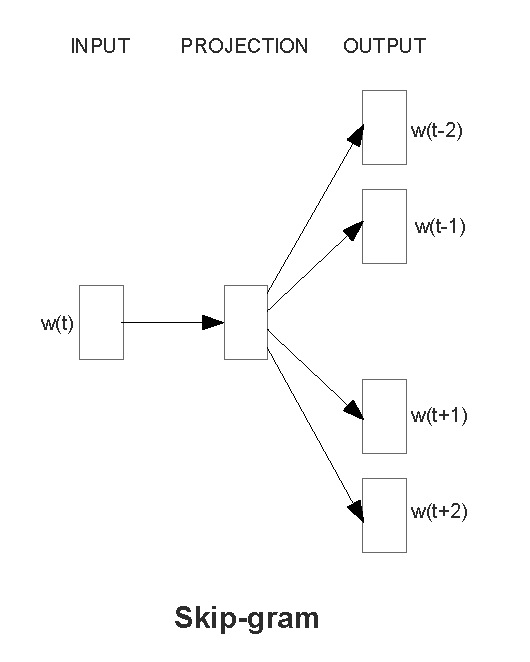

- 가운데의 층을 신경망 모델을 사용해도 되고 단순한 완전연결계층을 이용한 행렬곱을 사용해도 됨
- 데이터가 커질수록 신경망 모델의 효율성, 성능이 높아지며 단순한 예제 데이터의 경우는 행렬곱으로도 충분함

In [91]:
# Input String : "Duct tape works anywhere. Duct tape is magic and should be worshiped."

v = ["duct", "tape", "work", "anywhere", "magic", "worship"]
print(len(v))
print(v[0])

6
duct


In [92]:
import numpy as np

In [93]:
np.random.seed(42)
input_array_tape=np.array([0,1,0,0,0,0]) #"tape"
input_weight_matrix = np.random.random_sample((6,3))
print(input_weight_matrix)

[[0.375 0.951 0.732]
 [0.599 0.156 0.156]
 [0.058 0.866 0.601]
 [0.708 0.021 0.97 ]
 [0.832 0.212 0.182]
 [0.183 0.304 0.525]]


In [94]:
projection = np.dot(input_array_tape,input_weight_matrix)
print(projection)

[0.599 0.156 0.156]


In [95]:
output_weight_matrix = np.random.random_sample((3,6))
print(output_weight_matrix)

[[0.432 0.291 0.612 0.139 0.292 0.366]
 [0.456 0.785 0.2   0.514 0.592 0.046]
 [0.608 0.171 0.065 0.949 0.966 0.808]]


In [96]:
output_array_for_input_tape_and_orange_output_context = np.dot(projection, output_weight_matrix)
print(output_array_for_input_tape_and_orange_output_context)

[0.425 0.323 0.408 0.312 0.418 0.353]


In [97]:
print(list(zip(v, output_array_for_input_tape_and_orange_output_context)))

[('duct', 0.42451663675598933), ('tape', 0.3234497105099373), ('work', 0.4075914505752598), ('anywhere', 0.3117602853605092), ('magic', 0.41795589389125587), ('worship', 0.35267831257488347)]


- 가장 높은 추론값을 가지는 것은
  1. duct (0.4245)
  2. magic (0.4179)
  3. work (0.4075)
<br><br>
- 주어진 문장: *duct* **tape** *work* anywhere *duct* **tape** *magic* worship